<h4>Алексеенко Дмитрий Алексеевич</h4>
https://t.me/Dmitriy_Glutok

# Тема проекта

<h1><b>Построение ML-продукта для оптимизации классификации заявок на оплату для сервиса Repetit.ru</b></h1>

#  Описание задачи

сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете, желаемой стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%. 

проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.

необходимо разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать вероятность оплаты заявки клиентом. Заказчик хочет понять, какие заявки будут оплачены, а какие нет, чтобы одни обрабатывать вручную консультантами, а другие нет. Оценка качества модели будет производиться с использованием precision и ROC-AUC. 

#  Описание данных

Заявки (orders.csv)
- order_date - дата создания 
- subject_id - предмет
- purpose - цель занятий
- lesson_price - цена
- lesson_duration - желаемая проодолжительность урока
- home_metro_id - ближайшее метро
- add_info - доп инфо
- start_date
- working_teacher_id
- status_id - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки)
- comments   
- amount_to_pay - сумма к оплате
- planned_lesson_number - клиент планирует N занятий
- first_lesson_date - дата 1 занятия
- coef - коэффициент
- creator_id - кто создал заявку (id сотрудника или клиента)
- pupil_category_new_id - возраст ученика
- lessons_per_week - занятий а неделю
- minimal_price
- teacher_sex - пол репетитора
- teacher_experience_from - опыт репетитора от
- teacher_experience_to- опыт репетитора до
- lesson_place_new - онлайн, у ученика, у учителя
- pupil_knowledgelvl -уровень знаний ученика
- teacher_age_from - желаемый возраст репеитора от
- teacher_age_to - желаемый возраст репеитора от
- chosen_teachers_only - не предлагать репетиторов кроме выбранных самостоятельно
- no_teachers_available - на заявку нет подходящих репов
- source_id - где создана заявка (какая часть сайта, не регион)
- original_order_id - дублем какой заявки является эта заявка
- client_id - айди клиента
- additional_status_id
- max_metro_distance - максимально готов ехать от метро
- estimated_fee 
- payment_date
- test_group - аб тесты
- is_display_to_teachers - хочет ли клиент получать отклики репетиторов



Репетиторы (teacher_info.csv)
- date_update
- reg_date
- birth_date
- teaching_start_date
- user_id - айди
- is_email_confirmed
- is_home_lessons
- is_external_lessons
- external_comments
- lesson_duration - продолжит урока
- lesson_cost - стоимость урока
- status_id
- status_relevant_date
- status_school_id
- status_college_id
- status_display
- russian_level_id
- home_country_id
- education
- information
- is_confirmed
- is_display - показывается в каталоге
- rating_id 
- rating - рейтинг
- comments
- rules_confirmed_date
- last_visited - послеждний визит
- is_pupils_needed - открыт для заявок
- is_cell_phone_confirmed
- effective_rating - какой-то еще рейтинг
- area_id
- registrar_id
- pupil_needed_date
- sex
- amount_to_pay - долг
- is_remote_lessons
- remote_comments
- show_on_map
- send_mailing
- send_suitable_orders
- rating_for_users - рейтинг 2
- rating_for_admin - рейтинг 3
- passport_id
- is_edited
- orders_allowed - разрешено назначать на заявки
- display_days
- verification_status_id
- is_individual
- partner_id
- star_rating - рейтинг 4
- rating_for_users_yesterday - рейтинг вчера
- review_num - отзывы
- relevance_date
- is_display_at_partners
- video_presentation_id - есть видеопрезентация
- status_institution_id
- Free_time_relevance_date


Подходящие по фильтру репетиторы (suitable_teachers.csv)
- tteacher_id - id репетитора
- order_id - id заявки
- contact_result    
- enable_auto_assign - доступен ли репетитор к работе или заблокирован (может ли репетитора назначить консультант и может ли он сам назначиться) (значение известно на момент подачи заявки)
- enable_assign - доступен ли репетитор к работе или заблокирован (может ли репетитора назначить консультант и может ли он сам назначиться) (значение известно на момент подачи заявки)


Желаемые репетиторы (prefered_teachers_order_id.csv)<br>
Репетиторы, которых клиент выбрал клиент.
- tteacher_id - id репетитора
- order_id - id заявки


In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

FIGSIZE_SQRT = (20,15)
FIGSIZE_LIN = (20,2)

In [2]:
orders = pd.read_feather('datasets/orders.feather')
suitable_teachers = pd.read_feather('datasets/suitable_teachers.feather')
teachers_info = pd.read_feather('datasets/teachers_info.feather')

In [3]:
orders.duplicated().sum()
orders = orders.drop_duplicates()
orders = orders.reset_index()

In [4]:
def target_class(num):
    if num == 5 or num ==6 or num ==13 or num ==15:
        return 1
    else: return 0
    
orders['target'] = orders['status_id'].apply(target_class)

In [5]:
%%time

dubli = orders.loc[~orders['original_order_id'].isna(),'original_order_id']
dubli_orders = orders.loc[(orders['id'].isin(dubli)) | (orders['original_order_id'].isin(dubli))]
t_max = dubli_orders.groupby('original_order_id')['target'].max()
for i in t_max.index:
    orders.loc[(orders['original_order_id'] == i) | (orders['id'] == i), 'target'] = t_max[i]

CPU times: total: 14min 16s
Wall time: 29min 38s


In [6]:
display(orders.sample(3))
orders.columns

,index,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,...,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,target
722164,317091,2905103,2023-10-22 21:31:45.267,18.0,Разделы: письмо.\nКатегория ученика: ребенок 6...,1200,60,None,2468.0,Район: м. Ховрино.\nМесто проведения занятий: ...,...,0,23,NaN,1257026,10.0,NaN,3480,None,1,0
193020,74530,1817831,2021-10-12 11:18:42.893,33.0,None,0,60,None,NaN,None,...,0,16,1817824.0,857468,7.0,NaN,None,None,1,0
316383,99776,2578395,2023-04-21 10:00:12.927,33.0,Разделы: украинский язык.\nКатегория ученика: ...,900,60,None,NaN,Количество занятий в неделю: 2-3.\nОпыт репети...,...,0,23,NaN,1135325,2.0,NaN,None,None,1,0


Index(['index', 'id', 'order_date', 'subject_id', 'purpose', 'lesson_price',
       'lesson_duration', 'lesson_place', 'home_metro_id', 'add_info',
       'start_date', 'working_teacher_id', 'status_id', 'comments',
       'prefered_teacher_id', 'amount_to_pay', 'planned_lesson_number',
       'first_lesson_date', 'creator_id', 'pupil_category_new_id',
       'lessons_per_week', 'minimal_price', 'teacher_sex',
       'teacher_experience_from', 'teacher_experience_to', 'lesson_place_new',
       'pupil_knowledgelvl', 'teacher_age_from', 'teacher_age_to',
       'chosen_teachers_only', 'no_teachers_available', 'source_id',
       'original_order_id', 'client_id', 'additional_status_id',
       'max_metro_distance', 'estimated_fee', 'payment_date',
       'is_display_to_teachers', 'target'],
      dtype='object')

In [7]:
# удаление столбцов с текстом (т.к. работать с текстом не успеваю. было бы время: ruBert-Tiny хотя бы), датами и утечками
orders = orders.drop(['order_date', 'add_info', 'start_date', 'working_teacher_id', 'comments', 'lesson_place'
                      , 'lesson_place_new', 'additional_status_id', 'estimated_fee', 'payment_date', 'first_lesson_date'
                      , 'lesson_place_new', 'prefered_teacher_id', 'purpose'], axis=1)
# удаление столбцов с пропусками
orders = orders.drop(['home_metro_id', 'creator_id', 'max_metro_distance'], axis = 1)

In [8]:
orders['amount_to_pay'] = orders['amount_to_pay'].str.replace(',','.')
orders['amount_to_pay'] = orders['amount_to_pay'].astype(float)

In [9]:
orders.isna().sum()

index                           0
id                              0
subject_id                  10325
lesson_price                    0
lesson_duration                 0
status_id                       0
amount_to_pay                   0
planned_lesson_number           0
pupil_category_new_id      159306
lessons_per_week                0
minimal_price                   0
teacher_sex                     0
teacher_experience_from         0
teacher_experience_to           0
pupil_knowledgelvl              0
teacher_age_from                0
teacher_age_to                  0
chosen_teachers_only            0
no_teachers_available           0
source_id                       0
original_order_id          608721
client_id                       0
is_display_to_teachers          0
target                          0
dtype: int64

In [10]:
orders = orders.dropna(subset=['subject_id', 'pupil_category_new_id'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1031129 entries, 2 to 1190960
Data columns (total 24 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   index                    1031129 non-null  int64  
 1   id                       1031129 non-null  int32  
 2   subject_id               1031129 non-null  float32
 3   lesson_price             1031129 non-null  int32  
 4   lesson_duration          1031129 non-null  int32  
 5   status_id                1031129 non-null  int32  
 6   amount_to_pay            1031129 non-null  float64
 7   planned_lesson_number    1031129 non-null  int32  
 8   pupil_category_new_id    1031129 non-null  float32
 9   lessons_per_week         1031129 non-null  int32  
 10  minimal_price            1031129 non-null  int32  
 11  teacher_sex              1031129 non-null  int32  
 12  teacher_experience_from  1031129 non-null  int32  
 13  teacher_experience_to    1031129 non-null  int3

C:\Users\gluto\AppData\Local\Temp\ipykernel_8888\1811416553.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize = FIGSIZE_LIN)


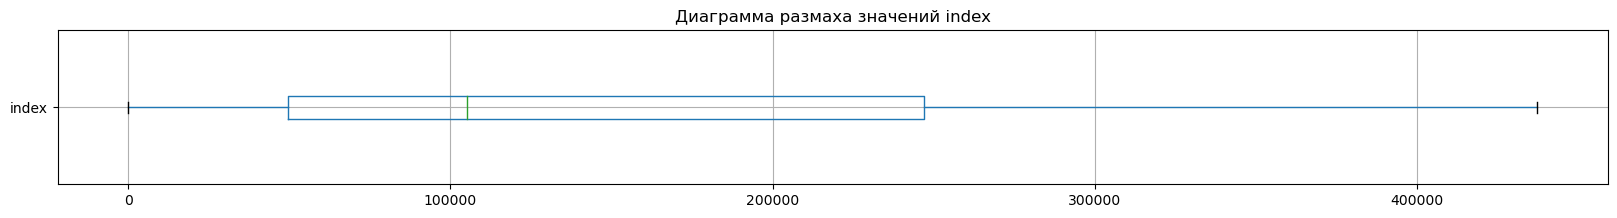

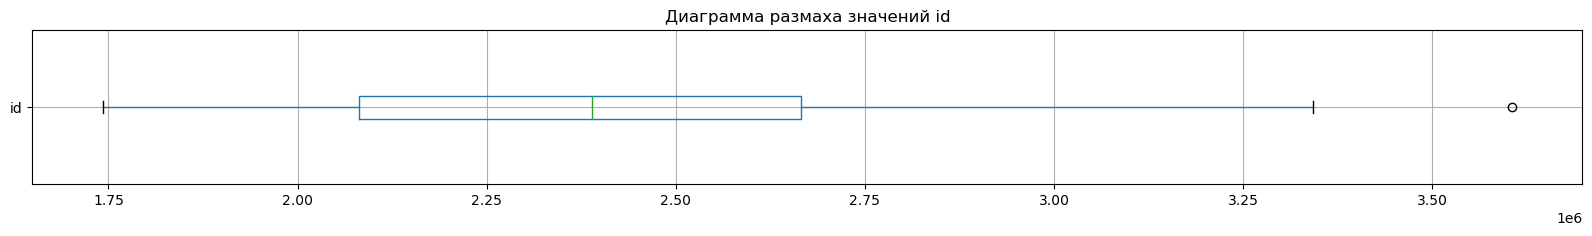

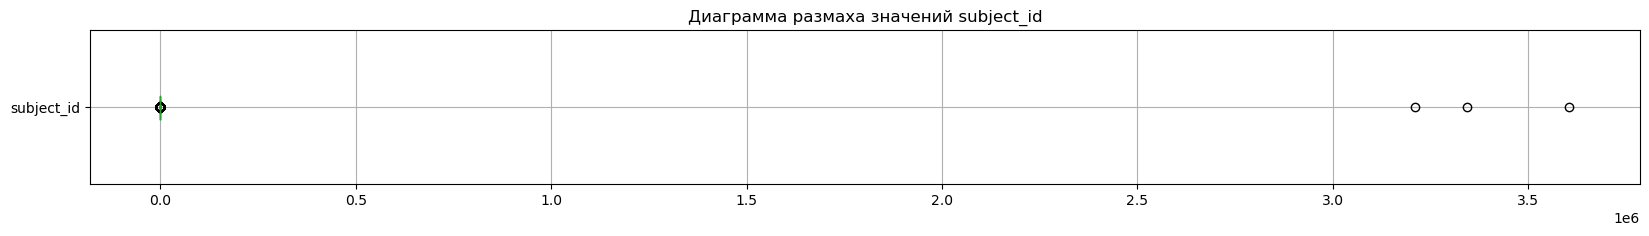

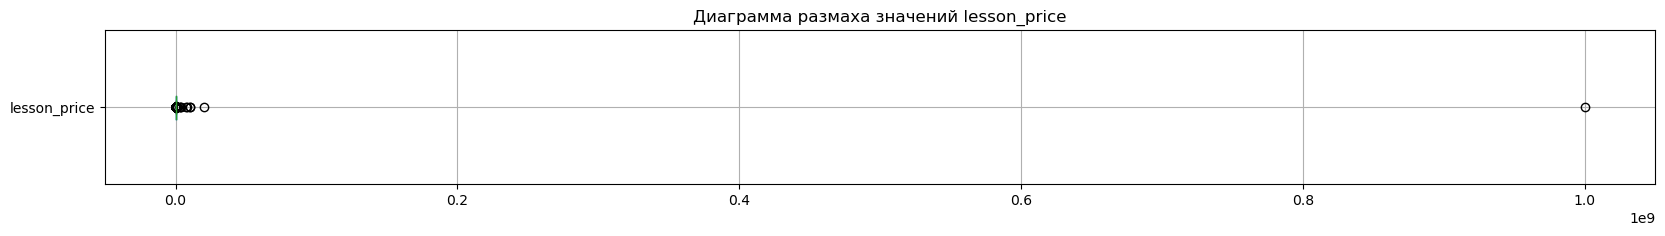

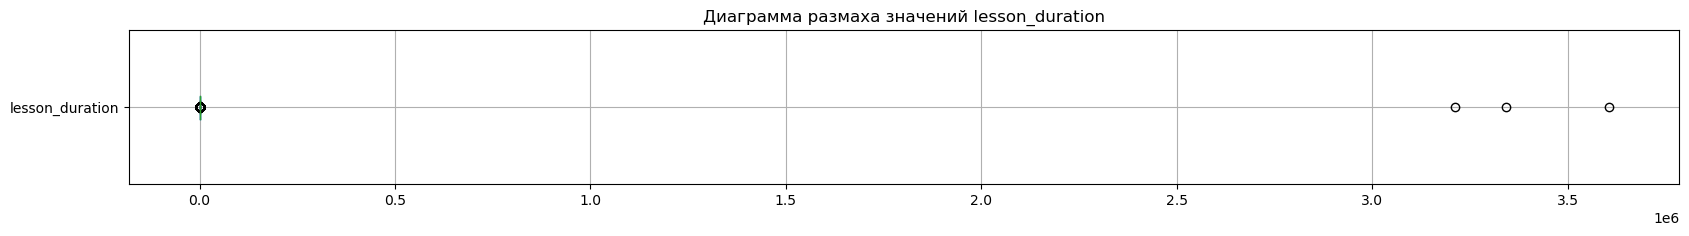

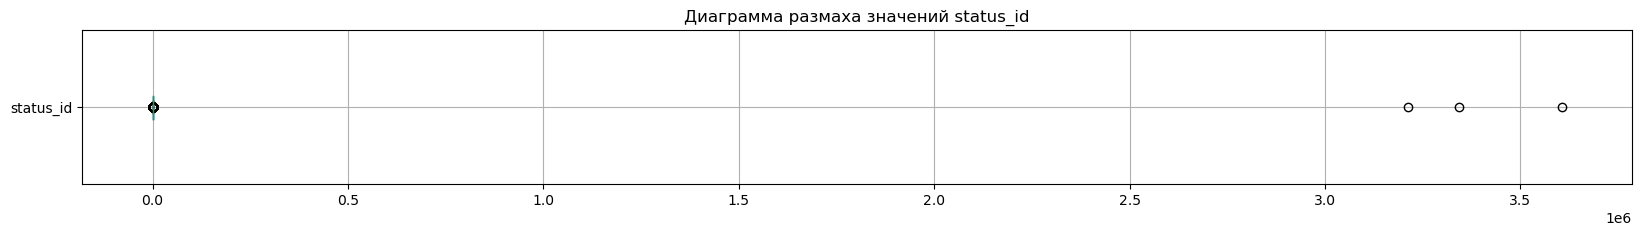

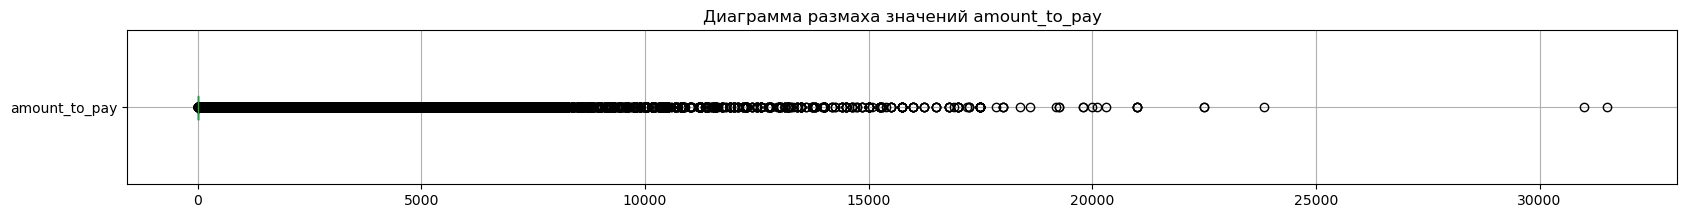

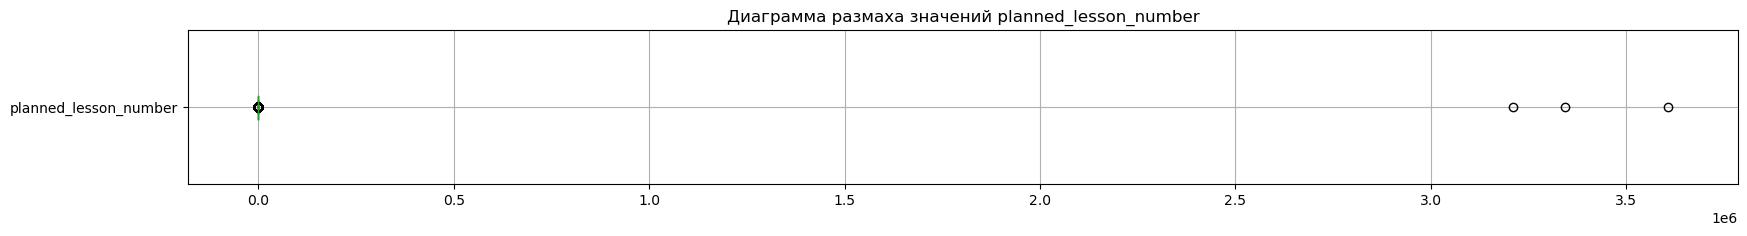

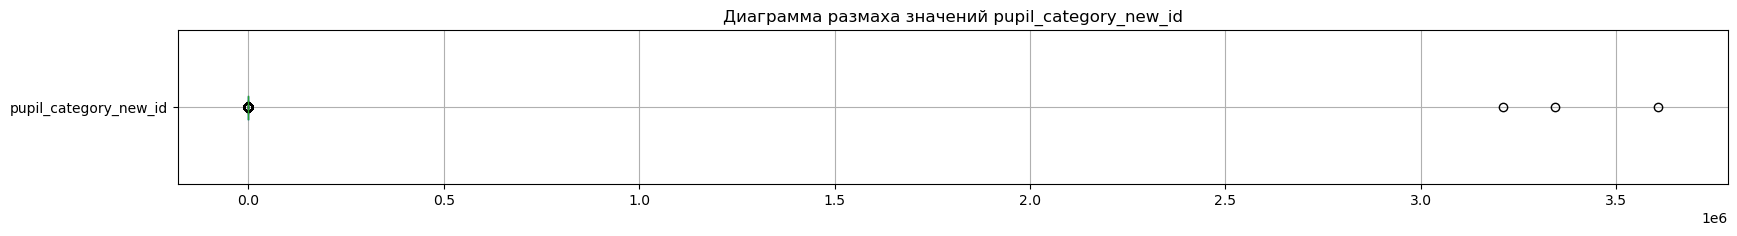

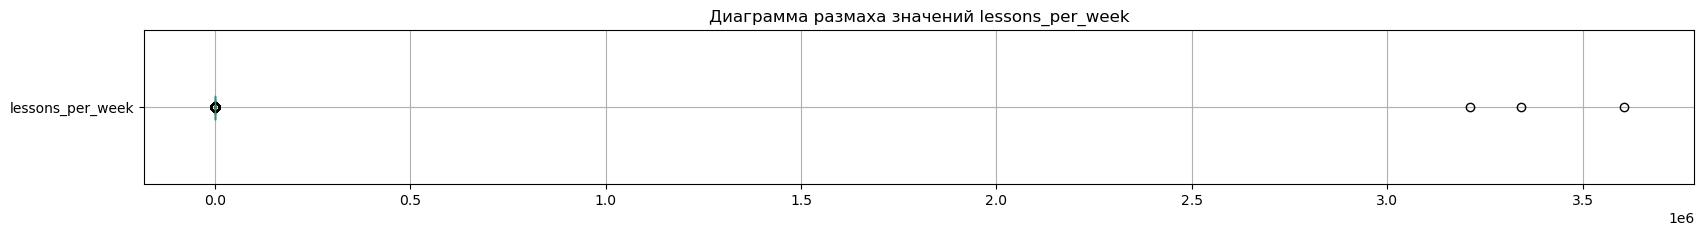

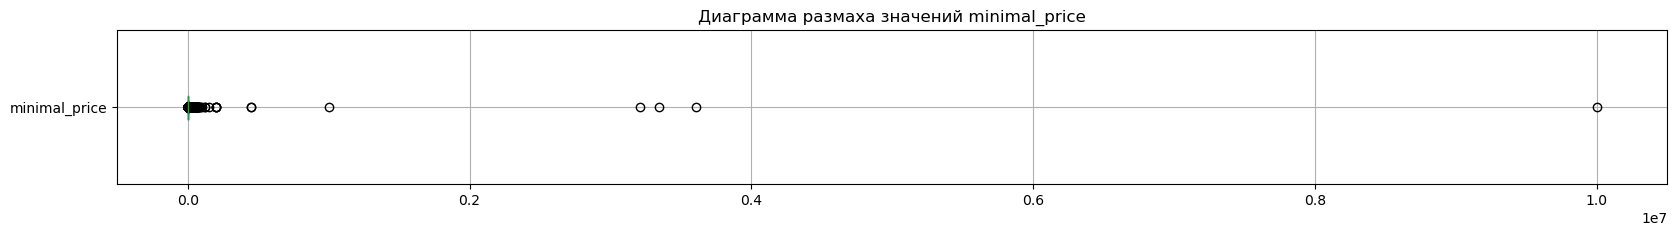

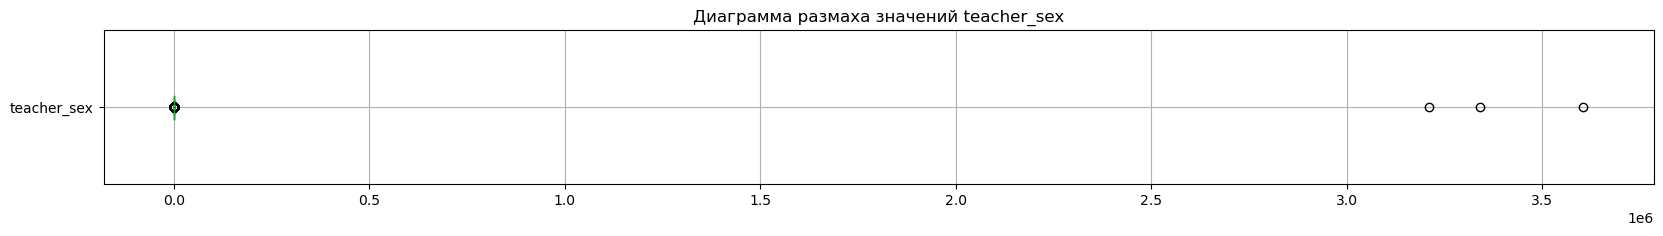

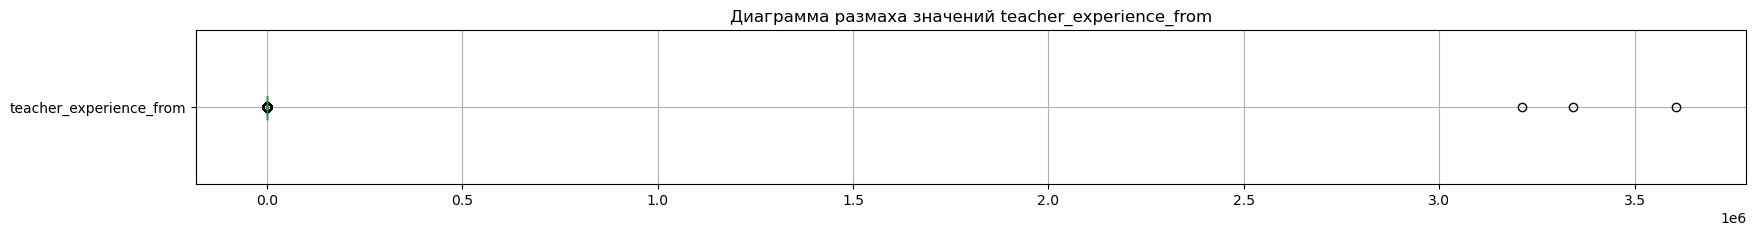

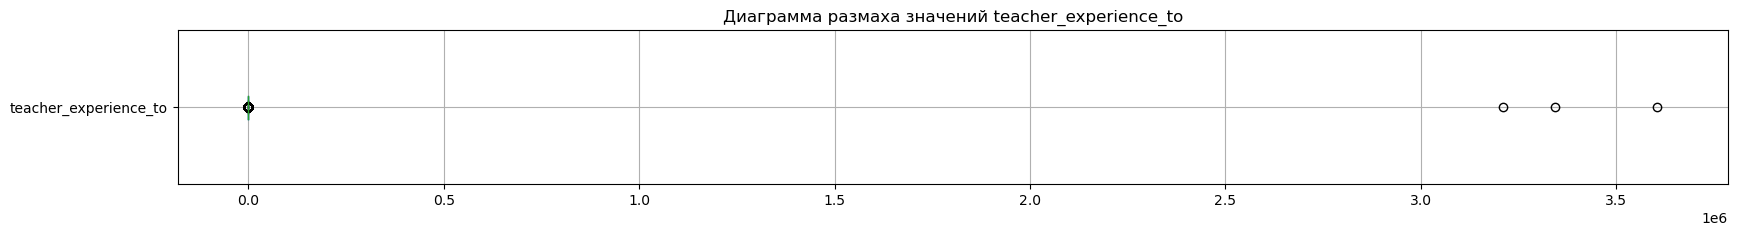

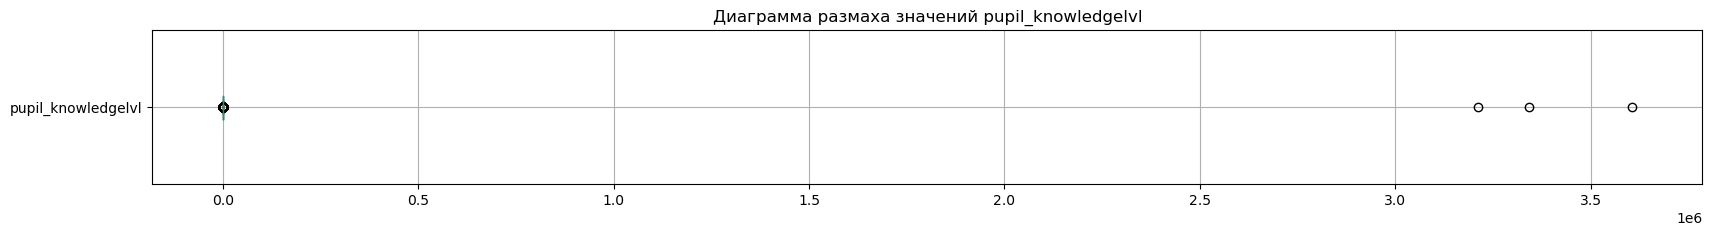

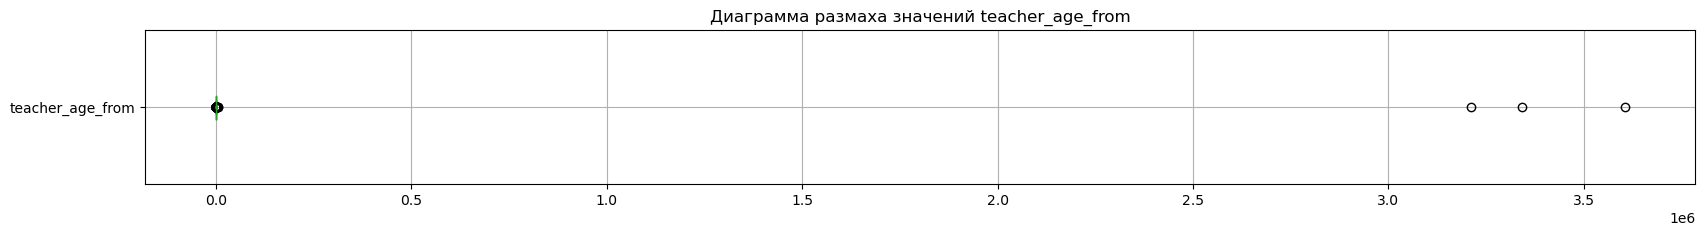

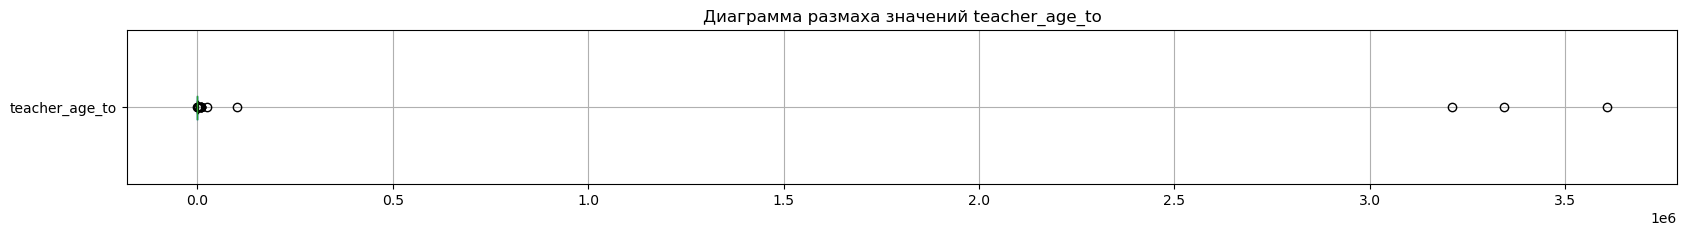

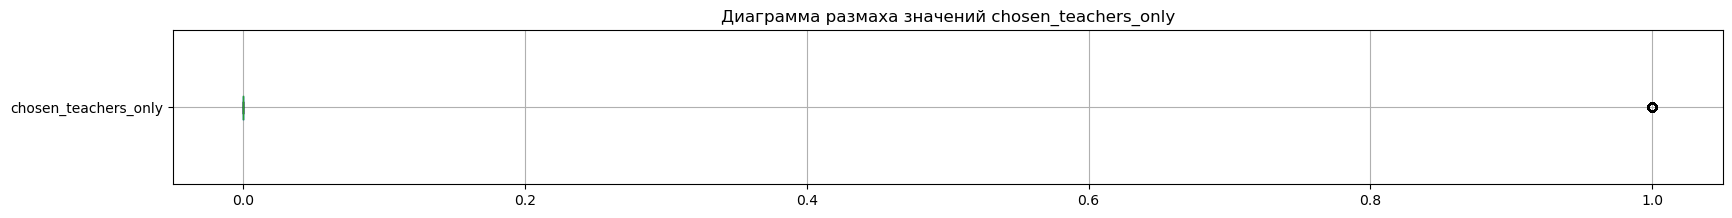

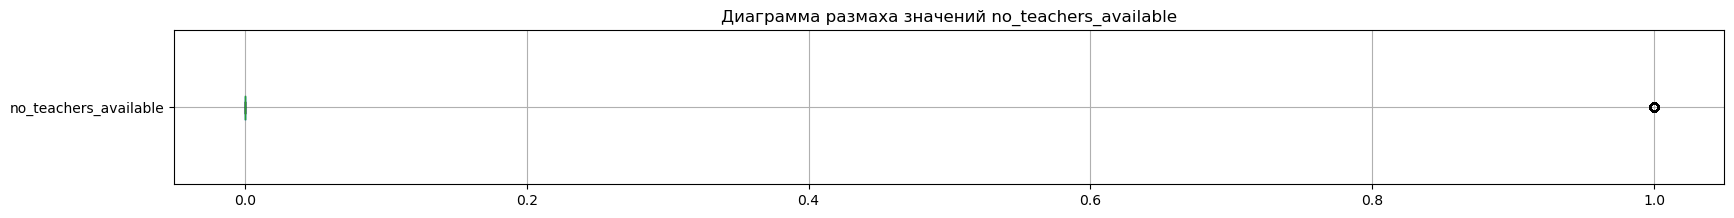

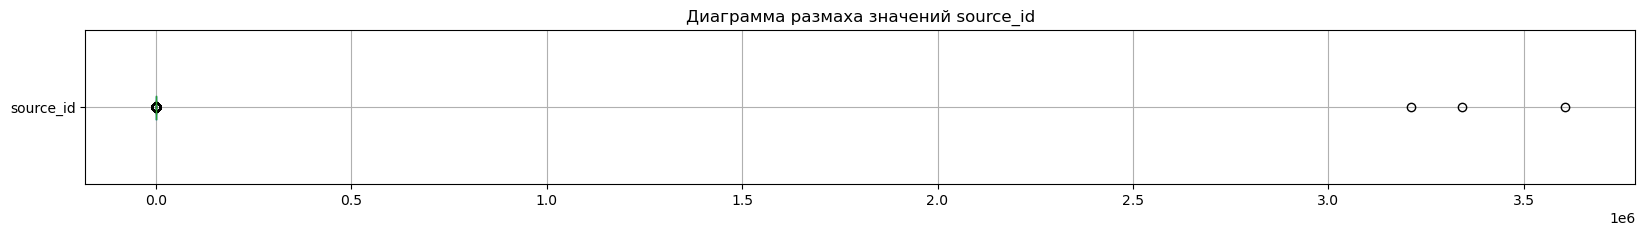

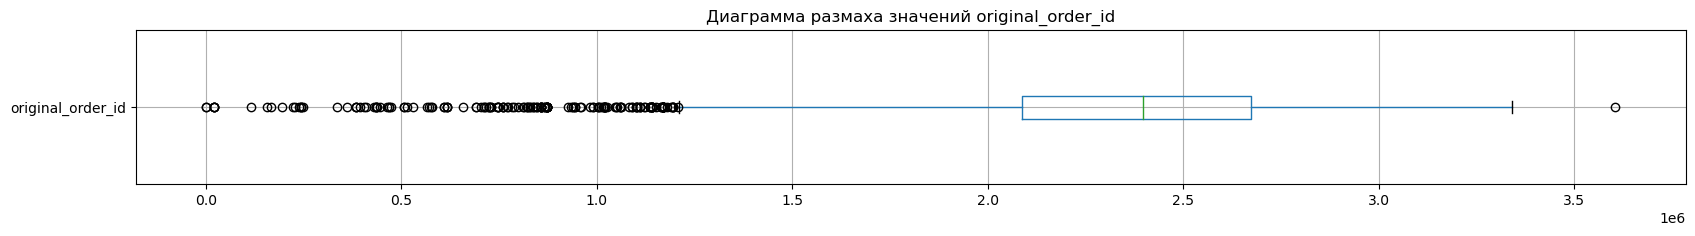

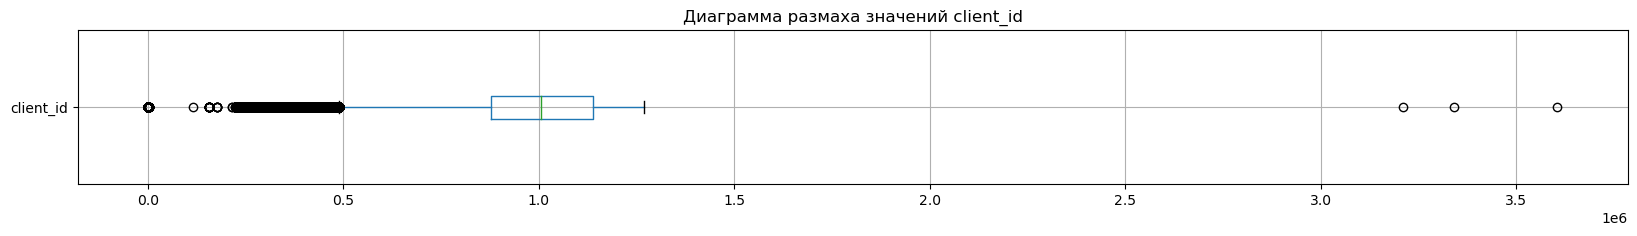

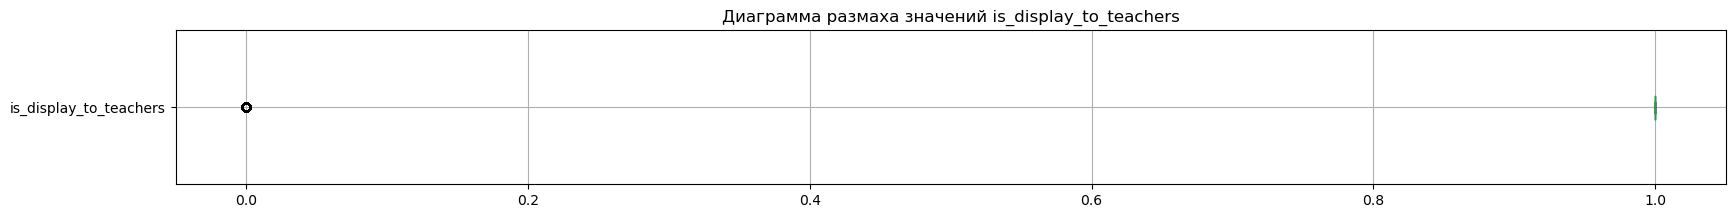

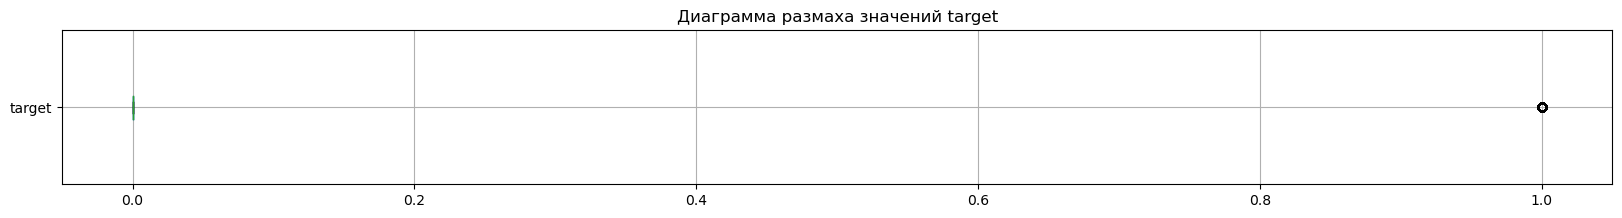

In [11]:
for i in orders.columns:
    fig, ax = plt.subplots(figsize = FIGSIZE_LIN)
    ax = orders[[i]].boxplot(vert = False, ax =ax)
    ax.set_title(f'Диаграмма размаха значений {i}');

In [12]:
# удаление выбросов верхний предел
spis_outliers = ['subject_id', 'lesson_price', 'lesson_duration', 'planned_lesson_number', 'pupil_category_new_id'
                 , 'lessons_per_week', 'teacher_sex', 'teacher_experience_from', 'teacher_experience_to'
                 , 'pupil_knowledgelvl', 'teacher_age_from', 'teacher_age_to', 'source_id']
for i in spis_outliers:
    orders = orders.loc[orders[i]<1000000]
    
print(len(orders))

1031119


C:\Users\gluto\AppData\Local\Temp\ipykernel_8888\1811416553.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize = FIGSIZE_LIN)


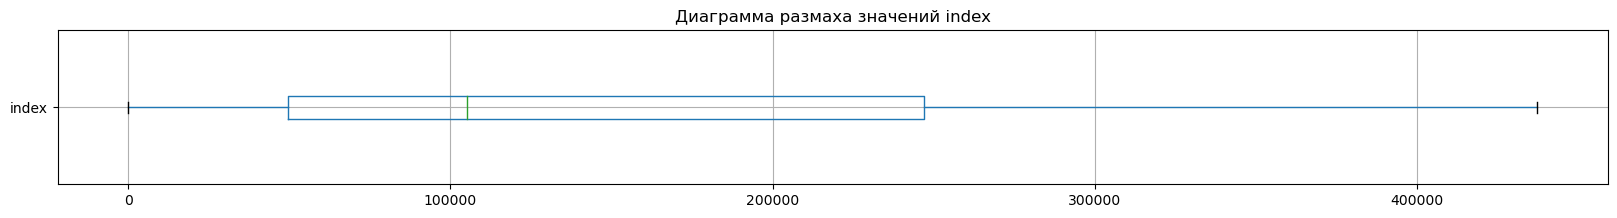

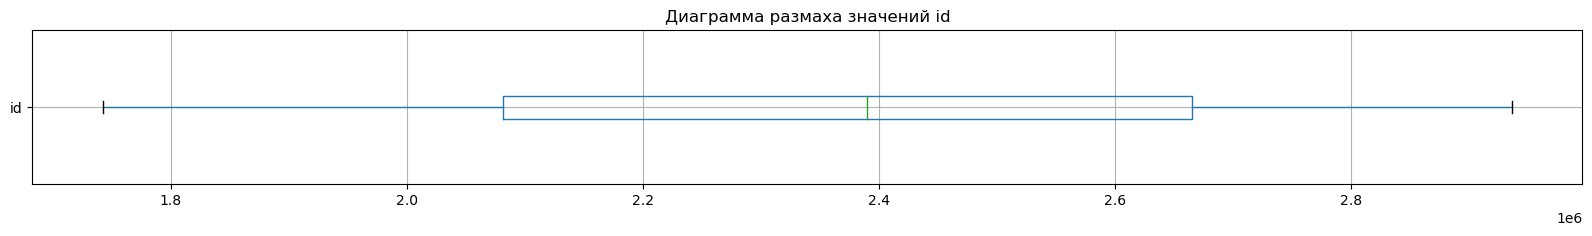

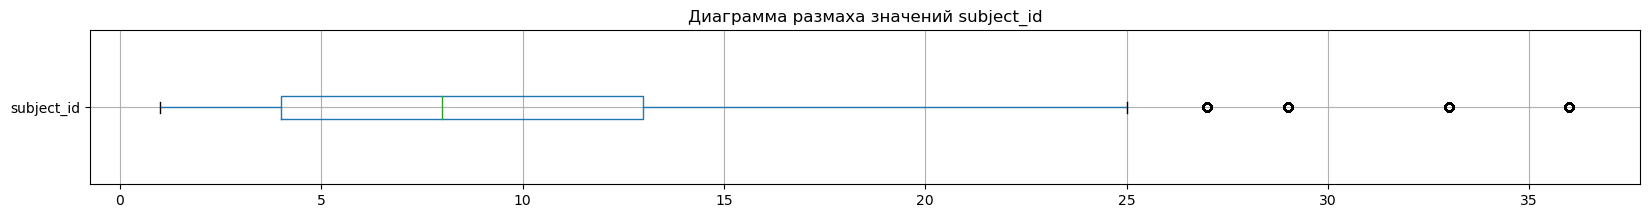

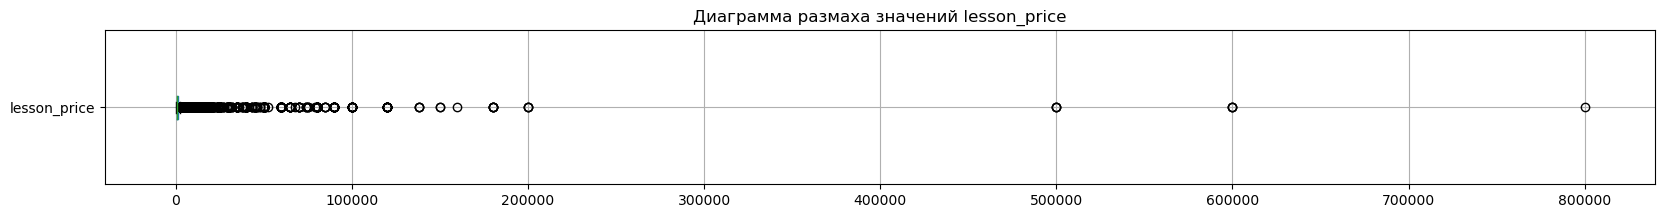

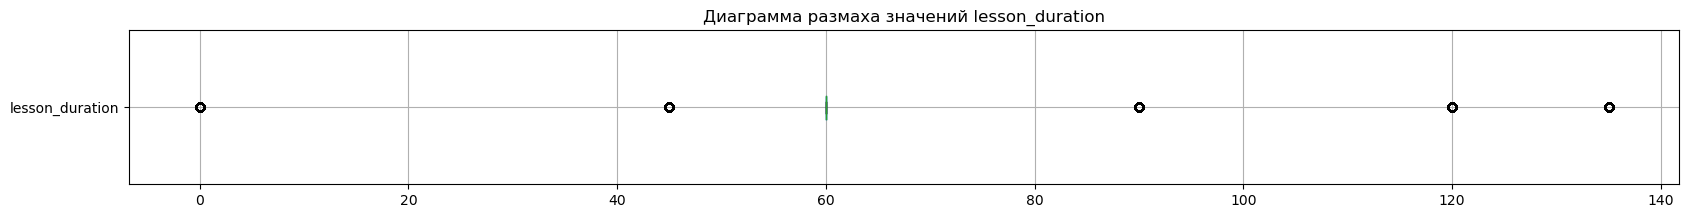

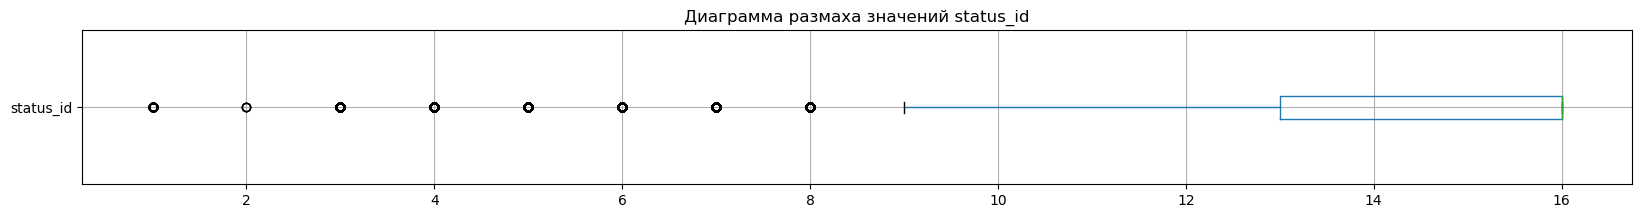

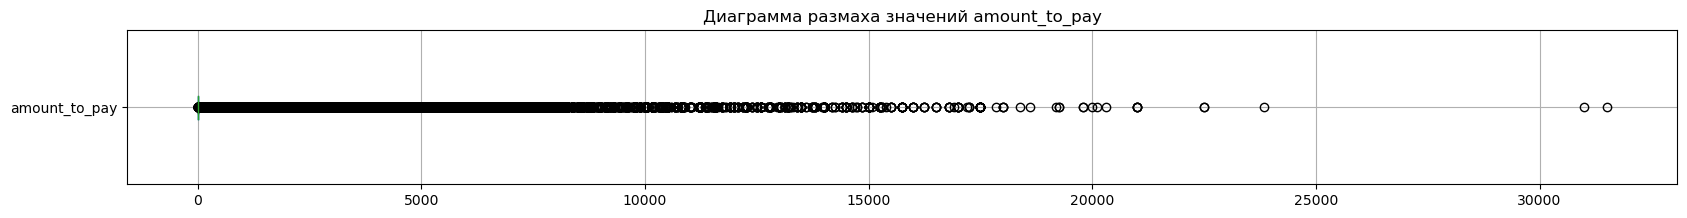

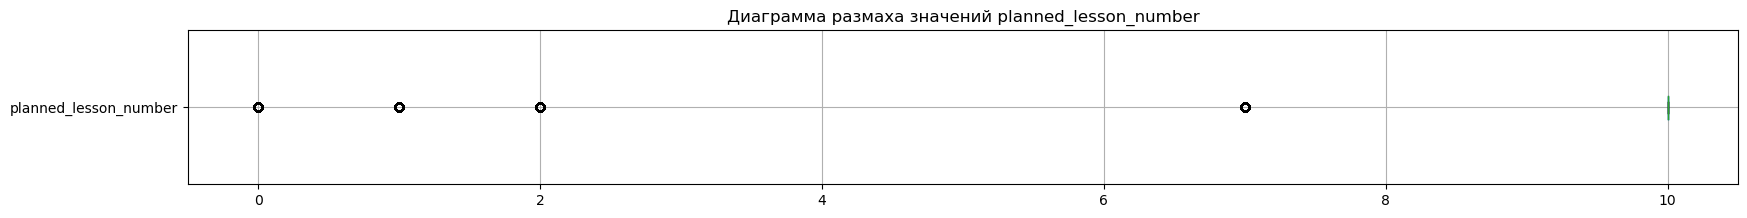

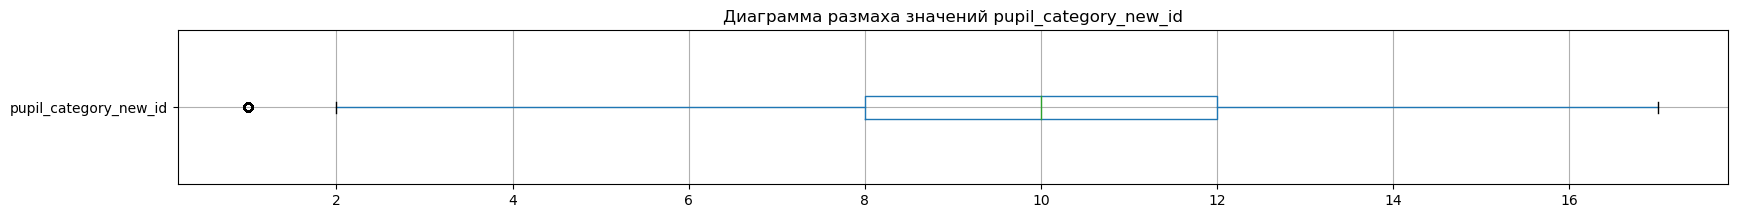

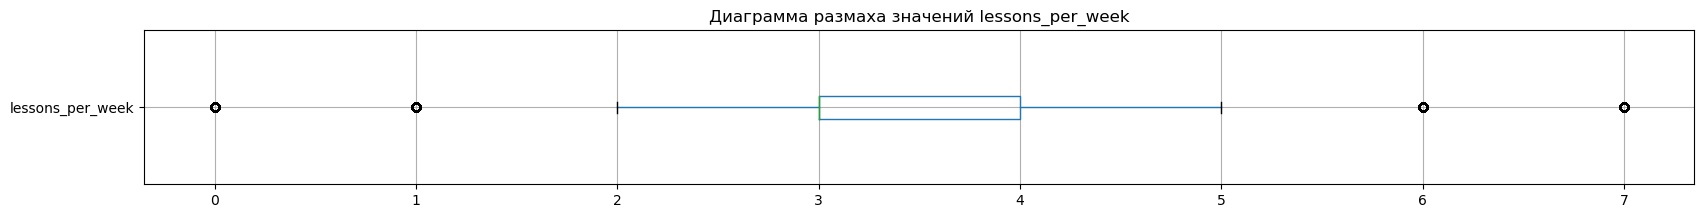

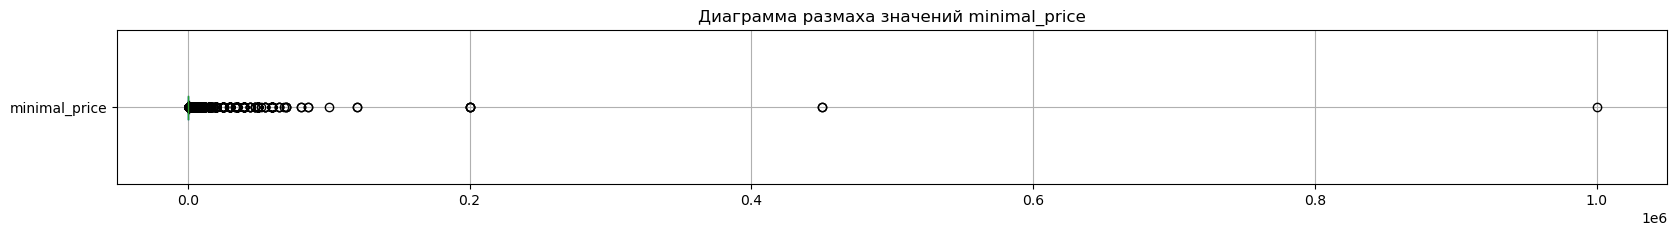

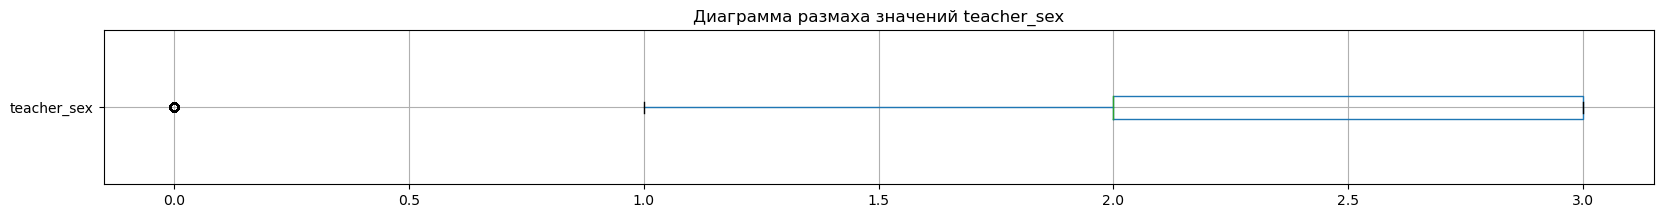

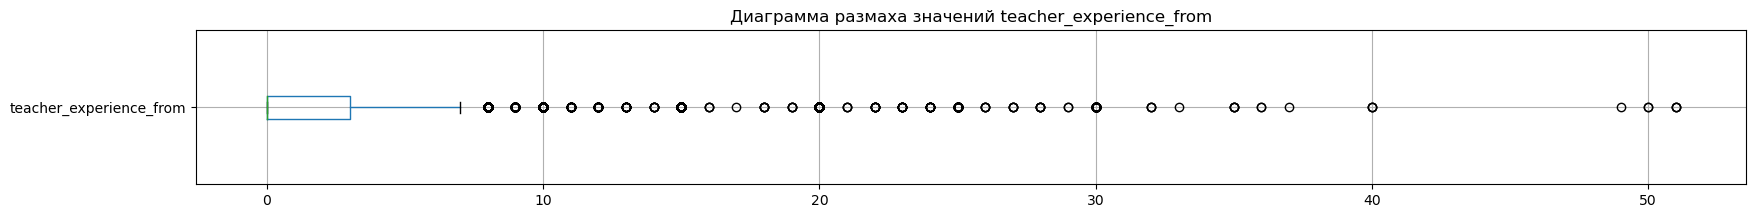

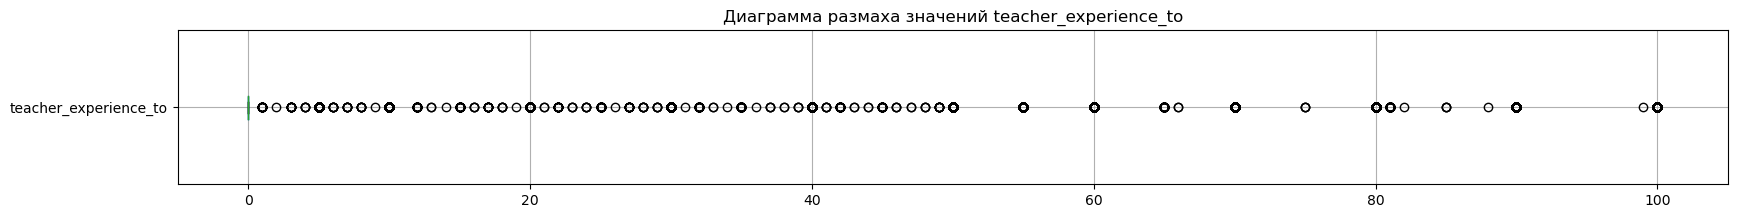

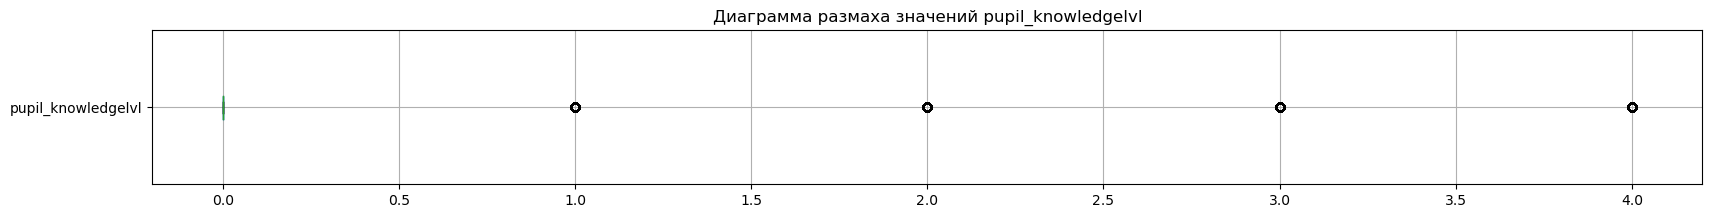

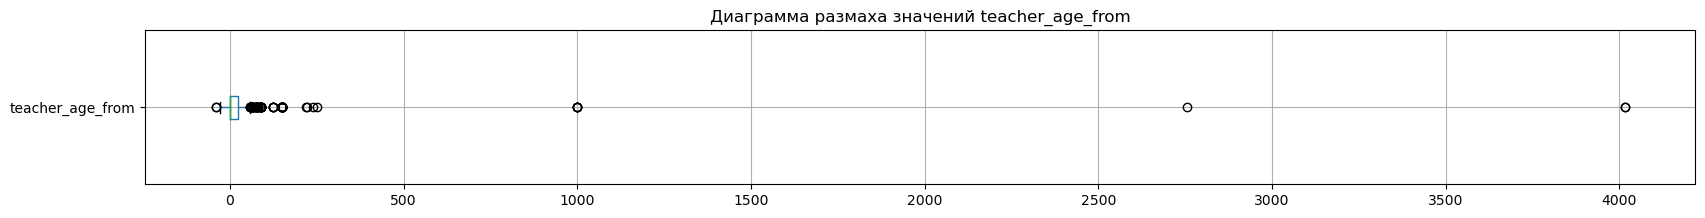

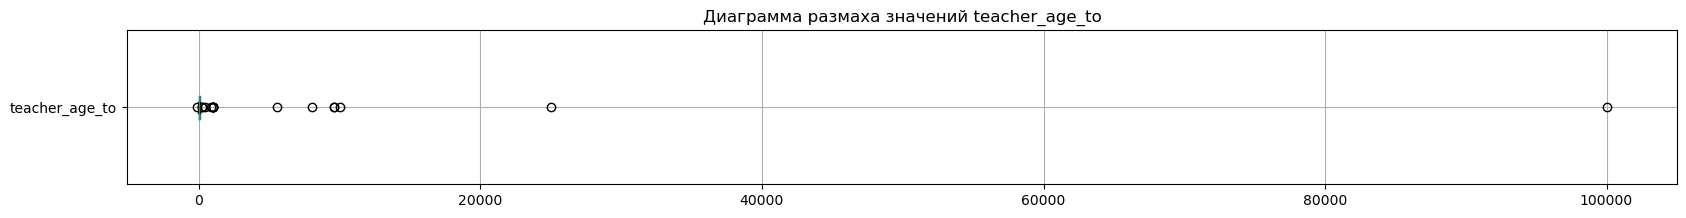

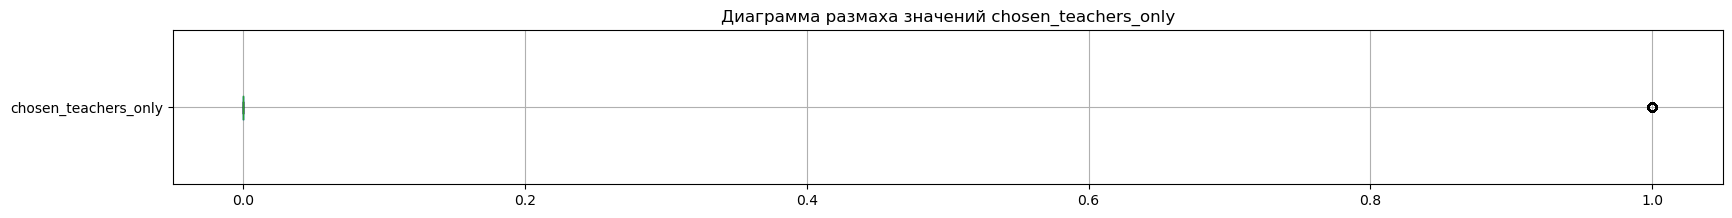

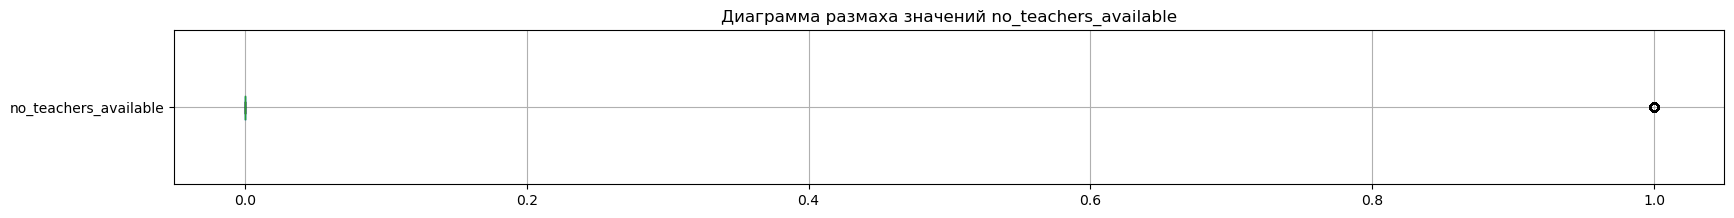

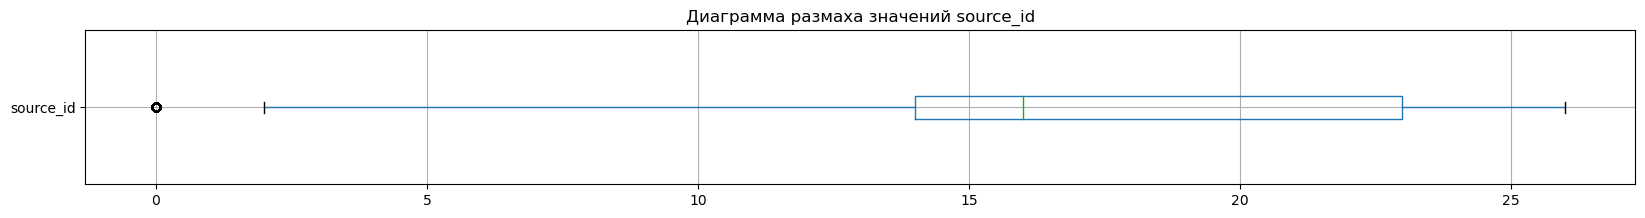

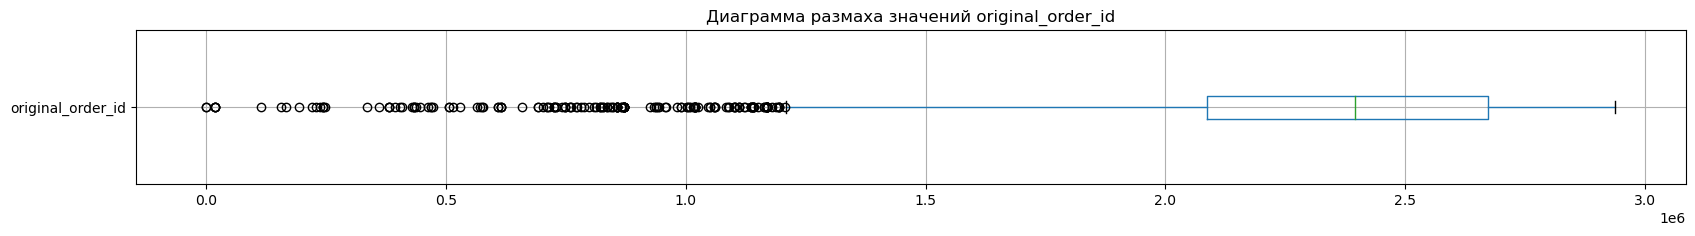

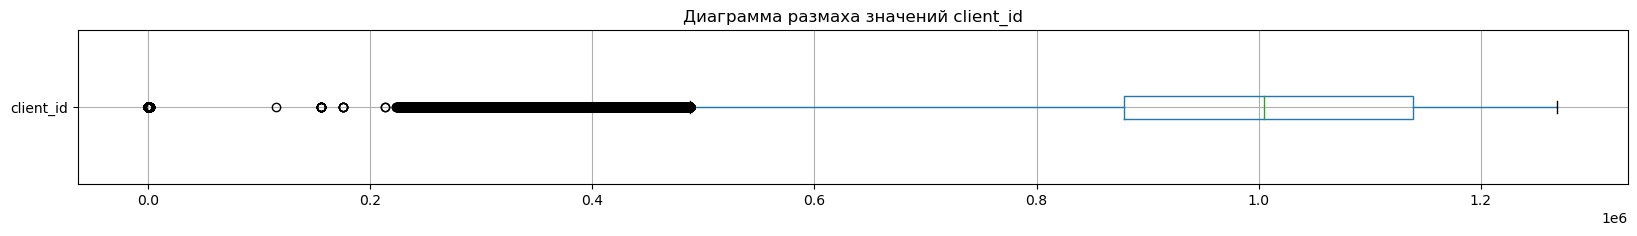

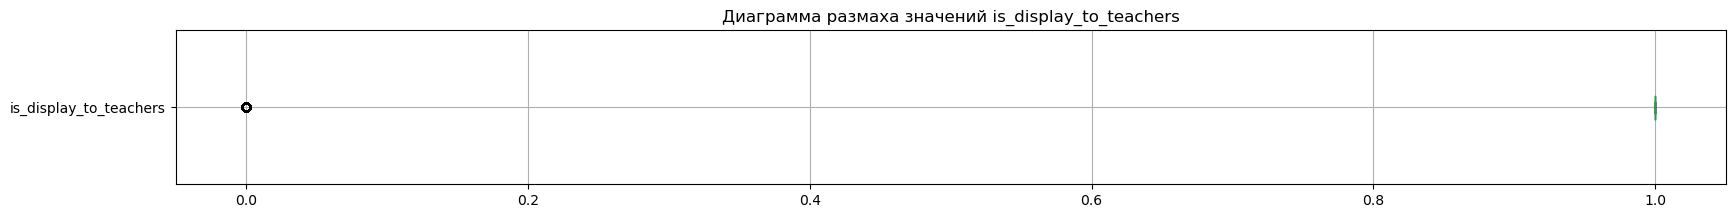

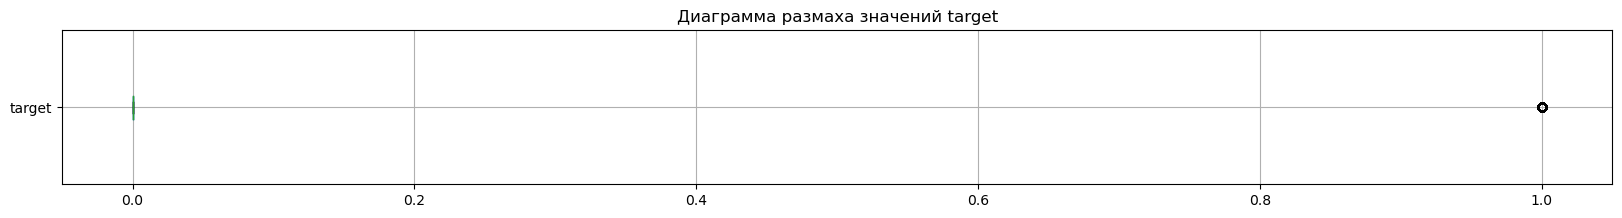

In [13]:
for i in orders.columns:
    fig, ax = plt.subplots(figsize = FIGSIZE_LIN)
    ax = orders[[i]].boxplot(vert = False, ax =ax)
    ax.set_title(f'Диаграмма размаха значений {i}');

In [14]:
# в teachers_info отберу столбцы, явно характеризующие репетитора

teachers_info = pd.read_feather('datasets/teachers_info.feather')
teachers_info = teachers_info[['id', 'user_id', 'lesson_duration','lesson_cost','is_display','rating','is_pupils_needed'
                               , 'effective_rating','rating_for_users','rating_for_admin','orders_allowed']]

teachers_info

,id,user_id,lesson_duration,lesson_cost,is_display,rating,is_pupils_needed,effective_rating,rating_for_users,rating_for_admin,orders_allowed
0,33,45,60,1000,1,5,1.0,4.679688,1138.0,237.5,0
1,46,63,60,500,0,-3,1.0,0.000000,25.0,0.0,1
2,51,68,60,1500,0,6,1.0,6.000000,300.0,0.0,1
3,52,69,60,1000,1,6,0.0,11.289062,135.0,0.0,1
4,54,70,45,400,0,-3,1.0,-5.000000,50.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
307967,312618,1334851,60,0,1,0,NaN,0.000000,0.0,0.0,0
307968,312619,1334853,60,0,1,0,NaN,0.000000,0.0,0.0,0
307969,312620,1334890,60,0,1,0,NaN,0.000000,0.0,0.0,1
307970,312621,1334892,60,0,1,0,NaN,0.000000,0.0,0.0,1


In [15]:
teachers_info.isna().sum()

id                       0
user_id                  0
lesson_duration          0
lesson_cost              0
is_display               0
rating                   0
is_pupils_needed    296764
effective_rating         0
rating_for_users         0
rating_for_admin         0
orders_allowed           0
dtype: int64

In [16]:
z = suitable_teachers.groupby('order_id')['teacher_id'].last()
zz = pd.DataFrame()
zz['order_id'] = z.index
zz['teacher_id'] = z.values
zz

,order_id,teacher_id
0,1742638,174486
1,1742639,201226
2,1742650,67011
3,1742651,193758
4,1742654,29879
...,...,...
842014,2946695,131871
842015,2946696,272374
842016,2946697,292878
842017,2946698,202451


In [17]:
orders.loc[(orders['id'].isin(zz['order_id'])) | (orders['original_order_id'].isin(zz['order_id'])), 'teacher_id'] = zz['teacher_id']


In [18]:
orders.loc[orders['teacher_id'].isin(teachers_info['user_id']), 'teacher_lesson_duration'] = teachers_info['lesson_duration']
orders.loc[orders['teacher_id'].isin(teachers_info['user_id']), 'teacher_lesson_cost'] = teachers_info['lesson_cost']
orders.loc[orders['teacher_id'].isin(teachers_info['user_id']), 'teacher_is_display'] = teachers_info['is_display']
orders.loc[orders['teacher_id'].isin(teachers_info['user_id']), 'teacher_rating'] = teachers_info['rating']
orders.loc[orders['teacher_id'].isin(teachers_info['user_id']), 'teacher_effective_rating'] = teachers_info['effective_rating']
orders.loc[orders['teacher_id'].isin(teachers_info['user_id']), 'teacher_rating_for_users'] = teachers_info['rating_for_users']
orders.loc[orders['teacher_id'].isin(teachers_info['user_id']), 'teacher_rating_for_admin'] = teachers_info['rating_for_admin']
orders.loc[orders['teacher_id'].isin(teachers_info['user_id']), 'teacher_orders_allowed'] = teachers_info['orders_allowed']
orders

,index,id,subject_id,lesson_price,lesson_duration,status_id,amount_to_pay,planned_lesson_number,pupil_category_new_id,lessons_per_week,...,target,teacher_id,teacher_lesson_duration,teacher_lesson_cost,teacher_is_display,teacher_rating,teacher_effective_rating,teacher_rating_for_users,teacher_rating_for_admin,teacher_orders_allowed
2,2,2294056,21.0,800,60,16,0.0,7,14.0,2,...,0,67011.0,60.0,1500.0,0.0,6.0,6.000000,300.0,0.0,1.0
3,3,2294057,8.0,700,60,16,0.0,10,10.0,3,...,0,193758.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,17,2294071,21.0,3000,60,16,0.0,10,14.0,5,...,0,21729.0,60.0,1000.0,1.0,7.0,12.742188,2038.0,1174.0,1.0
18,18,2294072,8.0,1500,60,16,0.0,10,9.0,2,...,0,170082.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,19,2294073,9.0,1500,60,16,0.0,1,14.0,2,...,0,233418.0,90.0,1200.0,0.0,-5.0,-1.111328,25.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190955,437211,2280502,13.0,900,60,16,0.0,10,10.0,3,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1190956,437212,2280503,9.0,1000,60,6,2650.0,10,8.0,2,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1190957,437213,2280504,1.0,1000,120,16,0.0,10,6.0,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1190958,437214,2280505,2.0,600,60,16,0.0,10,2.0,3,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
orders.isna().sum()

index                            0
id                               0
subject_id                       0
lesson_price                     0
lesson_duration                  0
status_id                        0
amount_to_pay                    0
planned_lesson_number            0
pupil_category_new_id            0
lessons_per_week                 0
minimal_price                    0
teacher_sex                      0
teacher_experience_from          0
teacher_experience_to            0
pupil_knowledgelvl               0
teacher_age_from                 0
teacher_age_to                   0
chosen_teachers_only             0
no_teachers_available            0
source_id                        0
original_order_id           567370
client_id                        0
is_display_to_teachers           0
target                           0
teacher_id                  375697
teacher_lesson_duration     943112
teacher_lesson_cost         943112
teacher_is_display          943112
teacher_rating      

In [20]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1031119 entries, 2 to 1190959
Data columns (total 33 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   index                     1031119 non-null  int64  
 1   id                        1031119 non-null  int32  
 2   subject_id                1031119 non-null  float32
 3   lesson_price              1031119 non-null  int32  
 4   lesson_duration           1031119 non-null  int32  
 5   status_id                 1031119 non-null  int32  
 6   amount_to_pay             1031119 non-null  float64
 7   planned_lesson_number     1031119 non-null  int32  
 8   pupil_category_new_id     1031119 non-null  float32
 9   lessons_per_week          1031119 non-null  int32  
 10  minimal_price             1031119 non-null  int32  
 11  teacher_sex               1031119 non-null  int32  
 12  teacher_experience_from   1031119 non-null  int32  
 13  teacher_experience_to     103111

In [21]:
orders = orders.fillna(0)
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1031119 entries, 2 to 1190959
Data columns (total 33 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   index                     1031119 non-null  int64  
 1   id                        1031119 non-null  int32  
 2   subject_id                1031119 non-null  float32
 3   lesson_price              1031119 non-null  int32  
 4   lesson_duration           1031119 non-null  int32  
 5   status_id                 1031119 non-null  int32  
 6   amount_to_pay             1031119 non-null  float64
 7   planned_lesson_number     1031119 non-null  int32  
 8   pupil_category_new_id     1031119 non-null  float32
 9   lessons_per_week          1031119 non-null  int32  
 10  minimal_price             1031119 non-null  int32  
 11  teacher_sex               1031119 non-null  int32  
 12  teacher_experience_from   1031119 non-null  int32  
 13  teacher_experience_to     103111

In [22]:
# дисбаланс классов:
weight_1 = len(orders.loc[orders['target'] == 1]) / len(orders.loc[orders['target'] == 0])
weight_0 = 1-weight_1
print('weight_0 = ',weight_0,' | weight_1 = ',weight_1)

weight_0 =  0.8074448029793091  | weight_1 =  0.19255519702069093


In [23]:
# вместо original_order_id поставлю признак- дубль
orders['dublicated'] = 0
orders.loc[~orders['original_order_id'].isna(), 'dublicated'] = 1

In [24]:
# удалю ненужные столбцы
orders = orders.drop(['id', 'status_id', 'original_order_id', 'client_id', 'teacher_id', 'index'], axis = 1)

In [43]:
# lesson_price заявки больше teacher_lesson_cost
# lesson_duration заявки меньше teacher_lesson_duration
orders['lesson_price_coincidence'] = 0
orders.loc[orders['lesson_price'] >= orders['teacher_lesson_cost'], 'lesson_price_coincidence'] = 1

orders['lesson_duration_coincidence'] = 0
orders.loc[orders['lesson_duration'] <= orders['teacher_lesson_duration'], 'lesson_duration_coincidence'] = 1

In [44]:
print(orders['lesson_price_coincidence'].sum())
print(orders['lesson_duration_coincidence'].sum())
len(orders)

1016613
77162


1031119

In [45]:
train, test = train_test_split(orders, test_size=0.3, random_state=12345, stratify = orders['target'])

In [46]:
train_features = train.drop('target', axis=1)
test_features = test.drop('target', axis=1)

train_target = train['target']
test_target = test['target']

In [47]:
scaler = StandardScaler()
scaler.fit(train_features)

train_features_scaled = scaler.transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [48]:
model_cb = CatBoostClassifier(class_weights={0:weight_1,1:weight_0})
model_cb.fit(train_features, train_target)
cb_preds = model_cb.predict(test_features)
print('roc_auc_score CatBoostClassifier = ', roc_auc_score(test_target, cb_preds))
print('precision CatBoostClassifier = ', precision_score(test_target, cb_preds))
print('recall CatBoostClassifier = ', recall_score(test_target, cb_preds))

Learning rate set to 0.171188
0:	learn: 0.6349732	total: 206ms	remaining: 3m 26s
1:	learn: 0.5987100	total: 267ms	remaining: 2m 13s
2:	learn: 0.5747187	total: 330ms	remaining: 1m 49s
3:	learn: 0.5609967	total: 393ms	remaining: 1m 37s
4:	learn: 0.5504875	total: 462ms	remaining: 1m 31s
5:	learn: 0.5435680	total: 530ms	remaining: 1m 27s
6:	learn: 0.5391470	total: 587ms	remaining: 1m 23s
7:	learn: 0.5353034	total: 650ms	remaining: 1m 20s
8:	learn: 0.5311463	total: 714ms	remaining: 1m 18s
9:	learn: 0.5291828	total: 778ms	remaining: 1m 17s
10:	learn: 0.5273307	total: 842ms	remaining: 1m 15s
11:	learn: 0.5261366	total: 909ms	remaining: 1m 14s
12:	learn: 0.5249585	total: 975ms	remaining: 1m 13s
13:	learn: 0.5241053	total: 1.05s	remaining: 1m 13s
14:	learn: 0.5234651	total: 1.1s	remaining: 1m 12s
15:	learn: 0.5226347	total: 1.17s	remaining: 1m 11s
16:	learn: 0.5221543	total: 1.24s	remaining: 1m 11s
17:	learn: 0.5216771	total: 1.3s	remaining: 1m 11s
18:	learn: 0.5206913	total: 1.37s	remaining: 1

161:	learn: 0.5064547	total: 11.5s	remaining: 59.7s
162:	learn: 0.5063987	total: 11.6s	remaining: 59.7s
163:	learn: 0.5063493	total: 11.7s	remaining: 59.7s
164:	learn: 0.5062919	total: 11.8s	remaining: 59.7s
165:	learn: 0.5062481	total: 11.9s	remaining: 59.7s
166:	learn: 0.5062011	total: 12s	remaining: 59.7s
167:	learn: 0.5061492	total: 12.1s	remaining: 59.8s
168:	learn: 0.5060869	total: 12.2s	remaining: 59.8s
169:	learn: 0.5060526	total: 12.3s	remaining: 59.9s
170:	learn: 0.5059911	total: 12.4s	remaining: 60s
171:	learn: 0.5059433	total: 12.5s	remaining: 60s
172:	learn: 0.5058958	total: 12.6s	remaining: 1m
173:	learn: 0.5058661	total: 12.6s	remaining: 1m
174:	learn: 0.5058154	total: 12.7s	remaining: 1m
175:	learn: 0.5057728	total: 12.8s	remaining: 60s
176:	learn: 0.5057218	total: 12.9s	remaining: 59.9s
177:	learn: 0.5056631	total: 13s	remaining: 59.9s
178:	learn: 0.5056329	total: 13.1s	remaining: 59.9s
179:	learn: 0.5056006	total: 13.1s	remaining: 59.8s
180:	learn: 0.5055645	total: 13

321:	learn: 0.5005325	total: 23.6s	remaining: 49.7s
322:	learn: 0.5005101	total: 23.7s	remaining: 49.7s
323:	learn: 0.5004705	total: 23.8s	remaining: 49.6s
324:	learn: 0.5004511	total: 23.8s	remaining: 49.5s
325:	learn: 0.5004281	total: 23.9s	remaining: 49.4s
326:	learn: 0.5003906	total: 24s	remaining: 49.3s
327:	learn: 0.5003561	total: 24.1s	remaining: 49.3s
328:	learn: 0.5003240	total: 24.1s	remaining: 49.2s
329:	learn: 0.5002956	total: 24.2s	remaining: 49.1s
330:	learn: 0.5002602	total: 24.3s	remaining: 49.1s
331:	learn: 0.5002259	total: 24.4s	remaining: 49s
332:	learn: 0.5001977	total: 24.4s	remaining: 49s
333:	learn: 0.5001564	total: 24.5s	remaining: 48.9s
334:	learn: 0.5001303	total: 24.6s	remaining: 48.8s
335:	learn: 0.5000786	total: 24.7s	remaining: 48.7s
336:	learn: 0.5000456	total: 24.7s	remaining: 48.7s
337:	learn: 0.5000284	total: 24.8s	remaining: 48.6s
338:	learn: 0.4999878	total: 24.9s	remaining: 48.5s
339:	learn: 0.4999539	total: 25s	remaining: 48.5s
340:	learn: 0.499912

480:	learn: 0.4955225	total: 34.9s	remaining: 37.7s
481:	learn: 0.4954907	total: 35s	remaining: 37.6s
482:	learn: 0.4954749	total: 35.1s	remaining: 37.6s
483:	learn: 0.4954487	total: 35.2s	remaining: 37.5s
484:	learn: 0.4954170	total: 35.2s	remaining: 37.4s
485:	learn: 0.4953936	total: 35.3s	remaining: 37.3s
486:	learn: 0.4953788	total: 35.4s	remaining: 37.3s
487:	learn: 0.4953503	total: 35.4s	remaining: 37.2s
488:	learn: 0.4953215	total: 35.5s	remaining: 37.1s
489:	learn: 0.4952946	total: 35.6s	remaining: 37s
490:	learn: 0.4952641	total: 35.7s	remaining: 37s
491:	learn: 0.4952469	total: 35.7s	remaining: 36.9s
492:	learn: 0.4952317	total: 35.8s	remaining: 36.8s
493:	learn: 0.4952207	total: 35.9s	remaining: 36.7s
494:	learn: 0.4952083	total: 35.9s	remaining: 36.7s
495:	learn: 0.4951872	total: 36s	remaining: 36.6s
496:	learn: 0.4951603	total: 36.1s	remaining: 36.5s
497:	learn: 0.4951335	total: 36.1s	remaining: 36.4s
498:	learn: 0.4951066	total: 36.2s	remaining: 36.3s
499:	learn: 0.495075

639:	learn: 0.4916368	total: 46.5s	remaining: 26.2s
640:	learn: 0.4916025	total: 46.6s	remaining: 26.1s
641:	learn: 0.4915669	total: 46.7s	remaining: 26s
642:	learn: 0.4915399	total: 46.7s	remaining: 25.9s
643:	learn: 0.4915205	total: 46.8s	remaining: 25.9s
644:	learn: 0.4915065	total: 46.9s	remaining: 25.8s
645:	learn: 0.4914875	total: 46.9s	remaining: 25.7s
646:	learn: 0.4914673	total: 47s	remaining: 25.7s
647:	learn: 0.4914509	total: 47.1s	remaining: 25.6s
648:	learn: 0.4914209	total: 47.2s	remaining: 25.5s
649:	learn: 0.4913871	total: 47.2s	remaining: 25.4s
650:	learn: 0.4913465	total: 47.3s	remaining: 25.4s
651:	learn: 0.4913149	total: 47.4s	remaining: 25.3s
652:	learn: 0.4912697	total: 47.5s	remaining: 25.2s
653:	learn: 0.4912440	total: 47.5s	remaining: 25.2s
654:	learn: 0.4912266	total: 47.6s	remaining: 25.1s
655:	learn: 0.4912120	total: 47.7s	remaining: 25s
656:	learn: 0.4911844	total: 47.8s	remaining: 24.9s
657:	learn: 0.4911573	total: 47.8s	remaining: 24.9s
658:	learn: 0.4911

799:	learn: 0.4880158	total: 58.1s	remaining: 14.5s
800:	learn: 0.4879764	total: 58.2s	remaining: 14.5s
801:	learn: 0.4879458	total: 58.3s	remaining: 14.4s
802:	learn: 0.4879237	total: 58.4s	remaining: 14.3s
803:	learn: 0.4878981	total: 58.4s	remaining: 14.2s
804:	learn: 0.4878563	total: 58.5s	remaining: 14.2s
805:	learn: 0.4878291	total: 58.6s	remaining: 14.1s
806:	learn: 0.4878163	total: 58.7s	remaining: 14s
807:	learn: 0.4877876	total: 58.8s	remaining: 14s
808:	learn: 0.4877714	total: 58.8s	remaining: 13.9s
809:	learn: 0.4877445	total: 58.9s	remaining: 13.8s
810:	learn: 0.4877155	total: 59s	remaining: 13.7s
811:	learn: 0.4877075	total: 59s	remaining: 13.7s
812:	learn: 0.4876875	total: 59.1s	remaining: 13.6s
813:	learn: 0.4876575	total: 59.2s	remaining: 13.5s
814:	learn: 0.4876409	total: 59.2s	remaining: 13.4s
815:	learn: 0.4876191	total: 59.3s	remaining: 13.4s
816:	learn: 0.4875972	total: 59.4s	remaining: 13.3s
817:	learn: 0.4875750	total: 59.5s	remaining: 13.2s
818:	learn: 0.487542

960:	learn: 0.4848331	total: 1m 10s	remaining: 2.84s
961:	learn: 0.4848251	total: 1m 10s	remaining: 2.77s
962:	learn: 0.4848140	total: 1m 10s	remaining: 2.7s
963:	learn: 0.4847967	total: 1m 10s	remaining: 2.62s
964:	learn: 0.4847715	total: 1m 10s	remaining: 2.55s
965:	learn: 0.4847544	total: 1m 10s	remaining: 2.48s
966:	learn: 0.4847282	total: 1m 10s	remaining: 2.4s
967:	learn: 0.4847107	total: 1m 10s	remaining: 2.33s
968:	learn: 0.4846923	total: 1m 10s	remaining: 2.26s
969:	learn: 0.4846668	total: 1m 10s	remaining: 2.19s
970:	learn: 0.4846449	total: 1m 10s	remaining: 2.11s
971:	learn: 0.4846245	total: 1m 10s	remaining: 2.04s
972:	learn: 0.4845915	total: 1m 10s	remaining: 1.97s
973:	learn: 0.4845714	total: 1m 11s	remaining: 1.9s
974:	learn: 0.4845571	total: 1m 11s	remaining: 1.82s
975:	learn: 0.4845281	total: 1m 11s	remaining: 1.75s
976:	learn: 0.4845188	total: 1m 11s	remaining: 1.68s
977:	learn: 0.4845037	total: 1m 11s	remaining: 1.6s
978:	learn: 0.4844842	total: 1m 11s	remaining: 1.5

In [49]:
model_rf = RandomForestClassifier(class_weight={0:weight_1,1:weight_0})
model_rf.fit(train_features, train_target)
rf_preds = model_rf.predict(test_features)
print('roc_auc_score RandomForestClassifier = ', roc_auc_score(test_target, rf_preds))
print('precision RandomForestClassifier = ', precision_score(test_target, rf_preds))
print('recall RandomForestClassifier = ', recall_score(test_target, rf_preds))

roc_auc_score RandomForestClassifier =  0.6911464730966259
precision RandomForestClassifier =  0.6100868590641636
recall RandomForestClassifier =  0.43594209862454203


In [50]:
model_dt = DecisionTreeClassifier(class_weight={0:weight_1,1:weight_0})
model_dt.fit(train_features, train_target)
dt_preds = model_dt.predict(test_features)
print('roc_auc_score DecisionTreeClassifier = ', roc_auc_score(test_target, dt_preds))
print('precision DecisionTreeClassifier = ', precision_score(test_target, dt_preds))
print('recall DecisionTreeClassifier = ', recall_score(test_target, dt_preds))

roc_auc_score DecisionTreeClassifier =  0.6792049207263733
precision DecisionTreeClassifier =  0.4230132594567282
recall DecisionTreeClassifier =  0.4860752397541394


In [51]:
model_lr = LogisticRegression(class_weight={0:weight_1,1:weight_0})
model_lr.fit(train_features, train_target)
lr_preds = model_lr.predict(test_features)
print('roc_auc_score LogisticRegression = ', roc_auc_score(test_target, lr_preds))
print('precision LogisticRegression = ', precision_score(test_target, lr_preds))
print('recall LogisticRegression = ', recall_score(test_target, lr_preds))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


roc_auc_score LogisticRegression =  0.6929928876940612
precision LogisticRegression =  0.575065240751164
recall LogisticRegression =  0.4500170180391215


проведу обучение с нормализованными значениями

In [52]:
model_cb = CatBoostClassifier(class_weights={0:weight_1,1:weight_0})
model_cb.fit(train_features_scaled, train_target)
cb_preds = model_cb.predict(test_features_scaled)
print('roc_auc_score CatBoostClassifier = ', roc_auc_score(test_target, cb_preds))
print('precision CatBoostClassifier = ', precision_score(test_target, cb_preds))
print('recall CatBoostClassifier = ', recall_score(test_target, cb_preds))

Learning rate set to 0.171188
0:	learn: 0.6349732	total: 79.6ms	remaining: 1m 19s
1:	learn: 0.5987100	total: 144ms	remaining: 1m 12s
2:	learn: 0.5747187	total: 210ms	remaining: 1m 9s
3:	learn: 0.5609967	total: 274ms	remaining: 1m 8s
4:	learn: 0.5504875	total: 343ms	remaining: 1m 8s
5:	learn: 0.5435680	total: 415ms	remaining: 1m 8s
6:	learn: 0.5391470	total: 474ms	remaining: 1m 7s
7:	learn: 0.5353034	total: 544ms	remaining: 1m 7s
8:	learn: 0.5311463	total: 609ms	remaining: 1m 7s
9:	learn: 0.5291828	total: 707ms	remaining: 1m 9s
10:	learn: 0.5273307	total: 769ms	remaining: 1m 9s
11:	learn: 0.5261366	total: 842ms	remaining: 1m 9s
12:	learn: 0.5249585	total: 906ms	remaining: 1m 8s
13:	learn: 0.5241053	total: 984ms	remaining: 1m 9s
14:	learn: 0.5234651	total: 1.05s	remaining: 1m 8s
15:	learn: 0.5226347	total: 1.11s	remaining: 1m 8s
16:	learn: 0.5221543	total: 1.18s	remaining: 1m 8s
17:	learn: 0.5216771	total: 1.25s	remaining: 1m 8s
18:	learn: 0.5206913	total: 1.33s	remaining: 1m 8s
19:	lear

158:	learn: 0.5063962	total: 19.6s	remaining: 1m 43s
159:	learn: 0.5063463	total: 19.7s	remaining: 1m 43s
160:	learn: 0.5063071	total: 19.9s	remaining: 1m 43s
161:	learn: 0.5062583	total: 20s	remaining: 1m 43s
162:	learn: 0.5062090	total: 20.2s	remaining: 1m 43s
163:	learn: 0.5061450	total: 20.3s	remaining: 1m 43s
164:	learn: 0.5061044	total: 20.4s	remaining: 1m 43s
165:	learn: 0.5060467	total: 20.6s	remaining: 1m 43s
166:	learn: 0.5060105	total: 20.7s	remaining: 1m 43s
167:	learn: 0.5059723	total: 20.8s	remaining: 1m 43s
168:	learn: 0.5059453	total: 21s	remaining: 1m 43s
169:	learn: 0.5058949	total: 21.1s	remaining: 1m 43s
170:	learn: 0.5058538	total: 21.3s	remaining: 1m 43s
171:	learn: 0.5058168	total: 21.4s	remaining: 1m 43s
172:	learn: 0.5057676	total: 21.5s	remaining: 1m 42s
173:	learn: 0.5057137	total: 21.7s	remaining: 1m 42s
174:	learn: 0.5056878	total: 21.8s	remaining: 1m 42s
175:	learn: 0.5056415	total: 22s	remaining: 1m 42s
176:	learn: 0.5056169	total: 22.1s	remaining: 1m 42s

314:	learn: 0.5004549	total: 42.2s	remaining: 1m 31s
315:	learn: 0.5004194	total: 42.3s	remaining: 1m 31s
316:	learn: 0.5003918	total: 42.5s	remaining: 1m 31s
317:	learn: 0.5003679	total: 42.6s	remaining: 1m 31s
318:	learn: 0.5003272	total: 42.7s	remaining: 1m 31s
319:	learn: 0.5003105	total: 42.8s	remaining: 1m 31s
320:	learn: 0.5002941	total: 43s	remaining: 1m 30s
321:	learn: 0.5002536	total: 43.1s	remaining: 1m 30s
322:	learn: 0.5002024	total: 43.2s	remaining: 1m 30s
323:	learn: 0.5001781	total: 43.3s	remaining: 1m 30s
324:	learn: 0.5001578	total: 43.4s	remaining: 1m 30s
325:	learn: 0.5001275	total: 43.6s	remaining: 1m 30s
326:	learn: 0.5001043	total: 43.7s	remaining: 1m 29s
327:	learn: 0.5000740	total: 43.8s	remaining: 1m 29s
328:	learn: 0.5000297	total: 44s	remaining: 1m 29s
329:	learn: 0.4999919	total: 44.1s	remaining: 1m 29s
330:	learn: 0.4999577	total: 44.2s	remaining: 1m 29s
331:	learn: 0.4999295	total: 44.4s	remaining: 1m 29s
332:	learn: 0.4998808	total: 44.5s	remaining: 1m 2

472:	learn: 0.4959155	total: 56.7s	remaining: 1m 3s
473:	learn: 0.4959001	total: 56.8s	remaining: 1m 2s
474:	learn: 0.4958656	total: 56.8s	remaining: 1m 2s
475:	learn: 0.4958362	total: 56.9s	remaining: 1m 2s
476:	learn: 0.4958089	total: 57s	remaining: 1m 2s
477:	learn: 0.4957744	total: 57s	remaining: 1m 2s
478:	learn: 0.4957537	total: 57.1s	remaining: 1m 2s
479:	learn: 0.4957401	total: 57.2s	remaining: 1m 1s
480:	learn: 0.4957210	total: 57.3s	remaining: 1m 1s
481:	learn: 0.4956883	total: 57.3s	remaining: 1m 1s
482:	learn: 0.4956763	total: 57.4s	remaining: 1m 1s
483:	learn: 0.4956523	total: 57.5s	remaining: 1m 1s
484:	learn: 0.4956182	total: 57.5s	remaining: 1m 1s
485:	learn: 0.4955783	total: 57.6s	remaining: 1m
486:	learn: 0.4955454	total: 57.7s	remaining: 1m
487:	learn: 0.4955115	total: 57.7s	remaining: 1m
488:	learn: 0.4954727	total: 57.8s	remaining: 1m
489:	learn: 0.4954551	total: 57.9s	remaining: 1m
490:	learn: 0.4954214	total: 57.9s	remaining: 1m
491:	learn: 0.4953862	total: 58s	r

635:	learn: 0.4918269	total: 1m 8s	remaining: 39.2s
636:	learn: 0.4918054	total: 1m 8s	remaining: 39s
637:	learn: 0.4917856	total: 1m 8s	remaining: 38.9s
638:	learn: 0.4917692	total: 1m 8s	remaining: 38.8s
639:	learn: 0.4917524	total: 1m 8s	remaining: 38.7s
640:	learn: 0.4917308	total: 1m 8s	remaining: 38.5s
641:	learn: 0.4917025	total: 1m 8s	remaining: 38.4s
642:	learn: 0.4916852	total: 1m 8s	remaining: 38.3s
643:	learn: 0.4916650	total: 1m 9s	remaining: 38.1s
644:	learn: 0.4916416	total: 1m 9s	remaining: 38s
645:	learn: 0.4916136	total: 1m 9s	remaining: 37.9s
646:	learn: 0.4915906	total: 1m 9s	remaining: 37.8s
647:	learn: 0.4915754	total: 1m 9s	remaining: 37.6s
648:	learn: 0.4915418	total: 1m 9s	remaining: 37.5s
649:	learn: 0.4915217	total: 1m 9s	remaining: 37.4s
650:	learn: 0.4914904	total: 1m 9s	remaining: 37.3s
651:	learn: 0.4914657	total: 1m 9s	remaining: 37.1s
652:	learn: 0.4914428	total: 1m 9s	remaining: 37s
653:	learn: 0.4914312	total: 1m 9s	remaining: 36.9s
654:	learn: 0.4914

791:	learn: 0.4884030	total: 1m 20s	remaining: 21s
792:	learn: 0.4883773	total: 1m 20s	remaining: 20.9s
793:	learn: 0.4883365	total: 1m 20s	remaining: 20.8s
794:	learn: 0.4883185	total: 1m 20s	remaining: 20.7s
795:	learn: 0.4882893	total: 1m 20s	remaining: 20.6s
796:	learn: 0.4882653	total: 1m 20s	remaining: 20.5s
797:	learn: 0.4882403	total: 1m 20s	remaining: 20.4s
798:	learn: 0.4882202	total: 1m 20s	remaining: 20.3s
799:	learn: 0.4882085	total: 1m 20s	remaining: 20.2s
800:	learn: 0.4881945	total: 1m 20s	remaining: 20.1s
801:	learn: 0.4881674	total: 1m 21s	remaining: 20s
802:	learn: 0.4881483	total: 1m 21s	remaining: 19.9s
803:	learn: 0.4881324	total: 1m 21s	remaining: 19.8s
804:	learn: 0.4881118	total: 1m 21s	remaining: 19.7s
805:	learn: 0.4880813	total: 1m 21s	remaining: 19.6s
806:	learn: 0.4880521	total: 1m 21s	remaining: 19.5s
807:	learn: 0.4880399	total: 1m 21s	remaining: 19.4s
808:	learn: 0.4880228	total: 1m 21s	remaining: 19.3s
809:	learn: 0.4880008	total: 1m 21s	remaining: 19.

946:	learn: 0.4852789	total: 1m 32s	remaining: 5.17s
947:	learn: 0.4852641	total: 1m 32s	remaining: 5.07s
948:	learn: 0.4852542	total: 1m 32s	remaining: 4.97s
949:	learn: 0.4852361	total: 1m 32s	remaining: 4.87s
950:	learn: 0.4852049	total: 1m 32s	remaining: 4.78s
951:	learn: 0.4851763	total: 1m 32s	remaining: 4.68s
952:	learn: 0.4851518	total: 1m 32s	remaining: 4.58s
953:	learn: 0.4851284	total: 1m 32s	remaining: 4.48s
954:	learn: 0.4851159	total: 1m 33s	remaining: 4.38s
955:	learn: 0.4850860	total: 1m 33s	remaining: 4.28s
956:	learn: 0.4850599	total: 1m 33s	remaining: 4.19s
957:	learn: 0.4850506	total: 1m 33s	remaining: 4.09s
958:	learn: 0.4850334	total: 1m 33s	remaining: 3.99s
959:	learn: 0.4850225	total: 1m 33s	remaining: 3.89s
960:	learn: 0.4849931	total: 1m 33s	remaining: 3.79s
961:	learn: 0.4849754	total: 1m 33s	remaining: 3.69s
962:	learn: 0.4849587	total: 1m 33s	remaining: 3.6s
963:	learn: 0.4849397	total: 1m 33s	remaining: 3.5s
964:	learn: 0.4849153	total: 1m 33s	remaining: 3

In [53]:
model_rf = RandomForestClassifier(class_weight={0:weight_1,1:weight_0})
model_rf.fit(train_features_scaled, train_target)
rf_preds = model_rf.predict(test_features_scaled)
print('roc_auc_score RandomForestClassifier = ', roc_auc_score(test_target, rf_preds))
print('precision RandomForestClassifier = ', precision_score(test_target, rf_preds))
print('recall RandomForestClassifier = ', recall_score(test_target, rf_preds))

roc_auc_score RandomForestClassifier =  0.6910865388702099
precision RandomForestClassifier =  0.61080231317725
recall RandomForestClassifier =  0.4356217590646085


In [54]:
model_dt = DecisionTreeClassifier(class_weight={0:weight_1,1:weight_0})
model_dt.fit(train_features_scaled, train_target)
dt_preds = model_dt.predict(test_features_scaled)
print('roc_auc_score DecisionTreeClassifier = ', roc_auc_score(test_target, dt_preds))
print('precision DecisionTreeClassifier = ', precision_score(test_target, dt_preds))
print('recall DecisionTreeClassifier = ', recall_score(test_target, dt_preds))

roc_auc_score DecisionTreeClassifier =  0.6788731449667171
precision DecisionTreeClassifier =  0.4229299363057325
recall DecisionTreeClassifier =  0.4852343484093139


In [55]:
model_lr = LogisticRegression(class_weight={0:weight_1,1:weight_0})
model_lr.fit(train_features_scaled, train_target)
lr_preds = model_lr.predict(test_features_scaled)
print('roc_auc_score LogisticRegression = ', roc_auc_score(test_target, lr_preds))
print('precision LogisticRegression = ', precision_score(test_target, lr_preds))
print('recall LogisticRegression = ', recall_score(test_target, lr_preds))

roc_auc_score LogisticRegression =  0.6944999507557769
precision LogisticRegression =  0.5271959952409815
recall LogisticRegression =  0.4701984103149338


наилучший roc_auc_score у CatBoostClassifier
наилучший precision у RandomForestClassifier
наилучший recall у CatBoostClassifier

считаю лучшим алгоритм CatBoostClassifier для данной задачи

In [56]:
a = pd.DataFrame()
a['features'] = train_features.columns
a['importance'] = model_rf.feature_importances_
a=a.sort_values('importance', ascending=False)
a

,features,importance
3,amount_to_pay,0.261395
5,pupil_category_new_id,0.100746
0,subject_id,0.093797
1,lesson_price,0.086004
6,lessons_per_week,0.068134
16,source_id,0.052635
13,teacher_age_to,0.043824
12,teacher_age_from,0.043331
8,teacher_sex,0.040630
9,teacher_experience_from,0.040480


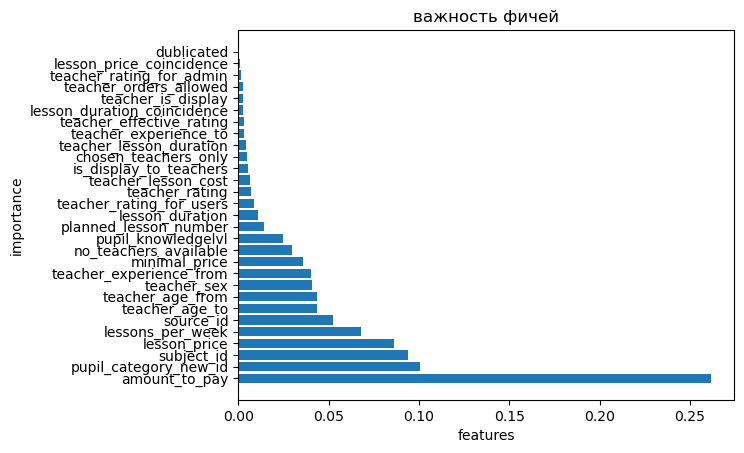

In [57]:
plt.barh(a['features'], a['importance'])
plt.title('важность фичей')
plt.xlabel('features')
plt.ylabel('importance')
plt.show()

# Вывод

были проанализированы данные по заявкам с сайта repetit.ru

построена модель ML для предсказания факта оплаты по заявке (двухклассовая классифиация)

наилучшим признан алгоритм CatBoostClassifier

по важности фичей выявлено, что самые полезные фичи следующие:
- amount_to_pay
- pupil_category_new_id
- subject_id
- lesson_price
- lessons_per_week

amount_to_pay вероятно с утечкой, возможно её бы убрать.
так же не проведена работа с текстовыми фичами (времени не хватило, к сожалению.)

возможное дальнейшее улучшение модели:
- проработать текстовые столбцы (как минимум purpose)
- генерить больше синтетических фичей